In [117]:
import numpy as np
import cv2
from tqdm.auto import tqdm

In [118]:
def read_video(video_path: str) -> np.array:
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    frames = []
    for _ in tqdm(range(frame_count), desc='Reading video'):
        ret, frame = cap.read()
        if not ret:
            break

        # converting to grayscale for simplicity
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))

    cap.release()
    frames = np.array(frames)

    return frames

In [119]:
def build_laplacian_pyramid(frame, levels=3):
    pyramid = []
    current_frame = frame
    
    for _ in range(levels - 1):
        down = cv2.pyrDown(current_frame)
        up = cv2.pyrUp(down, dstsize=(current_frame.shape[1], current_frame.shape[0]))
        laplacian = cv2.subtract(current_frame, up)
        pyramid.append(laplacian)
        current_frame = down

    pyramid.append(current_frame)
    return pyramid

In [120]:
def temporal_filter(frame, band_pass_low, band_pass_high, fps):
    fft = np.fft.fft(frame, axis=0)
    frequencies = np.fft.fftfreq(frame.shape[0], d=1 / fps)
    mask = np.logical_and(frequencies >= band_pass_low, frequencies <= band_pass_high)
    fft[~mask] = 0
    filtered = np.real(np.fft.ifft(fft, axis=0))
    return filtered

In [121]:
def amplify_motion(pyramid, alpha):
    for level in range(len(pyramid)):
        # pyramid[level] *= alpha
        pyramid[level] = cv2.convertScaleAbs(pyramid[level] * alpha, alpha=1 / 255.0)
    return pyramid

In [122]:
def reconstruct_from_laplacian(pyramid):
    frame = pyramid[-1]
    levels = len(pyramid)
    for level in range(levels - 1, 0, -1):
        frame = cv2.pyrUp(frame, dstsize=(pyramid[level - 1].shape[1], pyramid[level - 1].shape[0]))
        frame = cv2.add(frame, pyramid[level - 1])
    return frame

In [123]:
def eulerian_magnification(frames: np.array, alpha, freq_low, freq_high, fps):
    magnified_frames = []

    # Display progress while processing with tqdm
    for frame in tqdm(frames, desc='Processing frames'):
        pyramid = build_laplacian_pyramid(frame)
        filtered = [temporal_filter(layer, freq_low, freq_high, fps) for layer in pyramid]
        amplified = amplify_motion(filtered, alpha)
        reconstructed_frame = reconstruct_from_laplacian(amplified)
        magnified_frames.append(reconstructed_frame)
    return magnified_frames

In [124]:
# video_path = '/Volumes/Patrick/Proband06/Logitech HD Pro Webcam C920.avi'
video_path = '/Users/patrick/Desktop/Proband06/Logitech HD Pro Webcam C920.avi'
frames = read_video(video_path)

Reading video:   0%|          | 0/3600 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Laplacian')

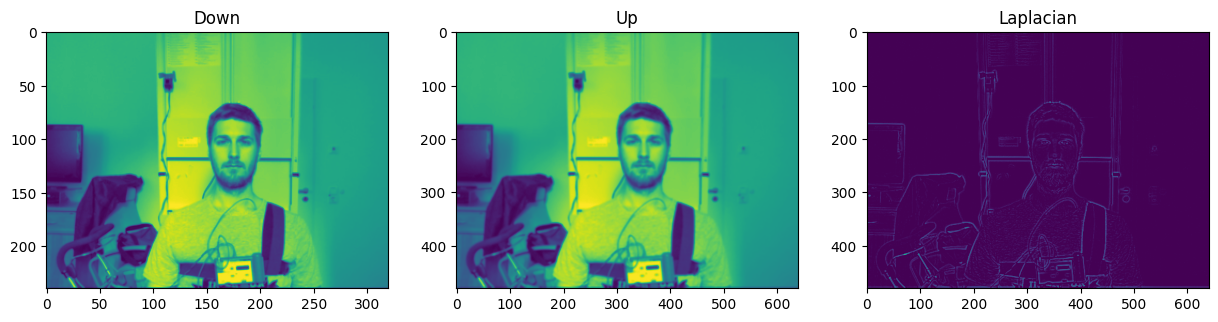

In [125]:
import matplotlib.pyplot as plt

down = cv2.pyrDown(frames[0])
up = cv2.pyrUp(down, dstsize=(frames[0].shape[1], frames[0].shape[0]))
laplacian = cv2.subtract(frames[0], up)

# Display up and down frames
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(down)
axs[0].set_title(f'Down')

axs[1].imshow(up)
axs[1].set_title(f'Up')

axs[2].imshow(laplacian)
axs[2].set_title(f'Laplacian')

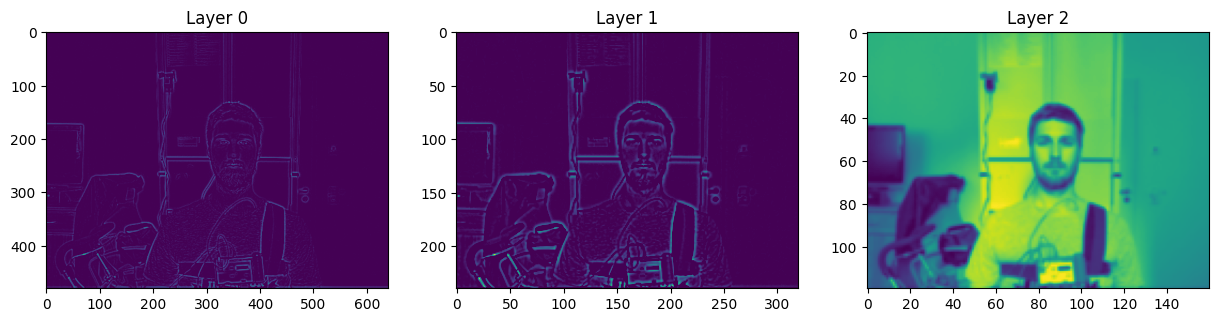

In [126]:
# Get the first frame
pyramid = build_laplacian_pyramid(frames[0], levels=3)

# Display the pyramid
fig, axs = plt.subplots(1, len(pyramid), figsize=(15, 5))
for inx, layer in enumerate(pyramid):
    axs[inx].imshow(layer)
    axs[inx].set_title(f'Layer {inx}')

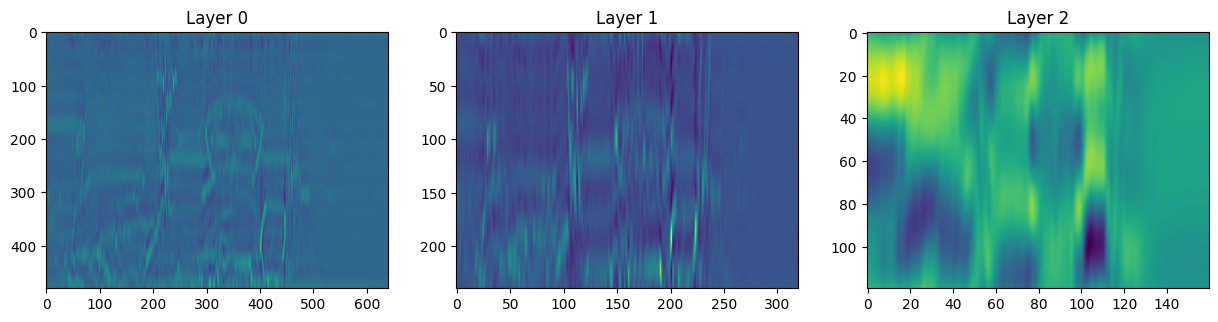

In [127]:
fig, axs = plt.subplots(1, len(pyramid), figsize=(15, 5))
filtered = []

for inx, layer in enumerate(pyramid):
    filters = temporal_filter(layer, 0.1, 0.7, 30)
    filtered.append(filters)
    axs[inx].imshow(filters)
    axs[inx].set_title(f'Layer {inx}')

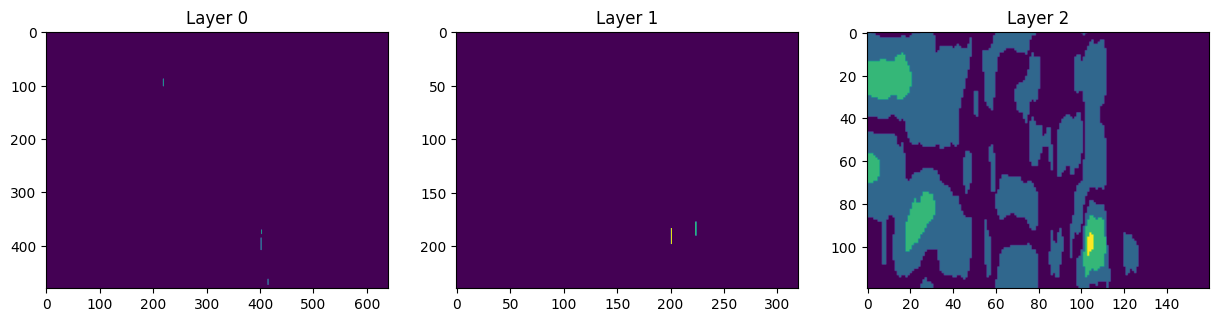

In [128]:
amplified = amplify_motion(filtered, 10)

fig, axs = plt.subplots(1, len(amplified), figsize=(15, 5))

for inx, layer in enumerate(amplified):
    axs[inx].imshow(layer)
    axs[inx].set_title(f'Layer {inx}')

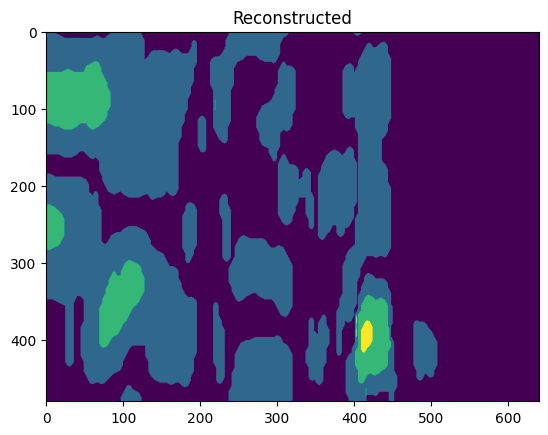

In [129]:
reconstructed = reconstruct_from_laplacian(amplified)

plt.imshow(reconstructed)
plt.title('Reconstructed')
plt.show()

In [130]:
magnified_frames = eulerian_magnification(frames, 7.5, 0.1, 0.7, 30)

Processing frames:   0%|          | 0/3600 [00:00<?, ?it/s]

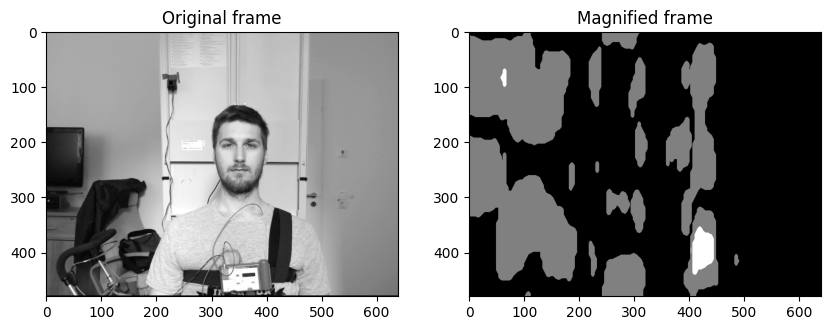

In [131]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(frames[0], cmap='gray')
axs[0].set_title('Original frame')

axs[1].imshow(magnified_frames[0], cmap='gray')
axs[1].set_title('Magnified frame')

plt.show()